In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.feature import hog

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Dataset
The dataset I chose is CMU face images from UCI Machine Learning Repository, the data is downloaded in to the folder named 'faces'.The dataset consists of 640 black-white face images of people taken with varying pose (straight, left, right, up), expression (neutral, happy, sad, angry), eyes (wearing sunglasses or not), and size(na,2,4). In the folder, photos of each person is saved in one folder with his/her name, each folder contains .pgm files, which is named in the format of name_pose_expression_eyes_size.pgm.

Source: Mitchell,Tom. (1999). CMU Face Images. UCI Machine Learning Repository. https://doi.org/10.24432/C5JC79.

As we can see displayed below are 9 photos of the first person(in first folder) in left posture, and from top to bottom, the facial expressions and eye conditionas for each row are angry-open, angry-sunglasses, and happy-open. From left to right, a larger number in size label means more blurry picture.

In [3]:
path = 'faces/'
folder = os.listdir(path)
if '.anonr' in folder:
    folder.remove('.anonr')

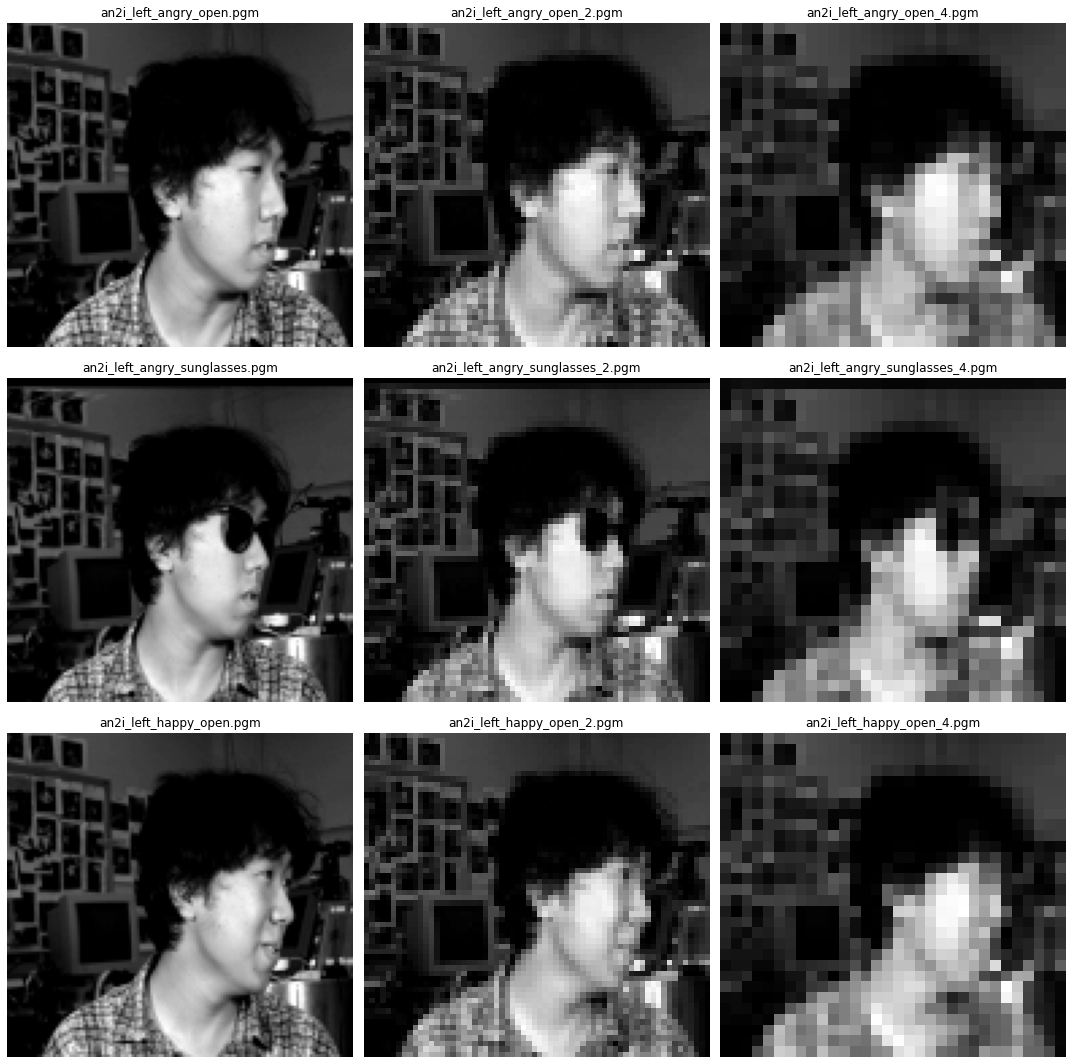

In [3]:
fd = 'an2i/'
photos = os.listdir(path+fd)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for ax, photo in zip(axes.flatten(), photos[:9]):
    img = cv2.imread(path+fd+photo, -1)

    ax.imshow(img, cmap='gray')
    ax.axis('off')  
    ax.set_title(photo)  
plt.tight_layout()
plt.show()

## Supervised learning problem
Problem to be solved: use the name, pose, expression, and eye as 4 dimensions of labels, apply classification methods to label the test set.
The photo files are name as a format name_pose_expression_eye_size.pgm, so I split the file name string and kept each first 4 words for labels.
I applied 3 methods of supervisedd methods to solve this problem: 1. Support Vector Machine with gaussian kernel, 2. Xgboost, 3. Convolution Neural Network.

### Data Preprocessing
Data is processed in two steps, firstly, I read in the pgm files as image, and resize the image to 224* 224* 3 shape, secondly, the data used in SVM is extracted features from the image data with Histogram of Oriented Gradients (Dalal and Triggs, 2005), and is scaled with max-min scaling. \

Hog is a widely used feature extracting method, which contains the procedures of 1. Data normalization, 2. Gradient calculation, 3. Orientation binning, 4. Descriptor blocks, 5. Feature vector. through this extraction, I obtain a lower dimension of image information which suits for SVM models. \

After the pre-processing, the dataset is devided into trainset and testset with percentage of 80%-20%, when trying to tune the hyperparameter in Xgboost and CNN, the train set is further devided randomly into 3-fold validation.

Data used in each model:

1. SVM: for X, HOG extrated features + max-min scaling; for y, 4 types of labels.
2. Xgboost: for X, HOG extrated features; for y, 4 types of labels transformed into digital classes.
3. CNN: for x, raw image pixels; for y, 4 types of labels transformed into one-hot labels.

In [4]:
def resize_image(image, size=(224, 224)):
    return cv2.resize(image, size)

def extractFeature(folder, hogEx):
    photos = os.listdir(folder)
    features = []
    labels = []
    for filename in photos:
        image_path = folder+filename
        if hogEx == True:
            resized_image = resize_image(cv2.imread(image_path, -1))
            feature, _ = hog(resized_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        else:
            feature = cv2.resize(cv2.imread(image_path), (224, 224))
                
        features.append(feature)
        labels.append(filename.split('.')[0].split('_')[:4])

    features = np.array(features)
    labels = np.array(labels)
    
    return features, labels
def trainTestDataPre(path,folder,hogEx=True):
    features, labels = extractFeature(path+folder[0]+'/',hogEx)
    for fd in folder[1:]:
        feature, label = extractFeature(path+fd+'/',hogEx)
        features = np.concatenate((features,feature))
        labels = np.concatenate((labels,label))
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [5]:
category = ['name','posture','facial expression','condition']
X_train, X_test, y_train, y_test = trainTestDataPre(path,folder)
X_train_img, X_test_img, y_train_img, y_test_img = trainTestDataPre(path,folder,hogEx=False)

### SVM model with rbf kernel
The rbf kernel is highly sensitive to outliners, so I scaled the HOG features with max-min scaling method first.

The Histogram of Oriented Gradients method goes through the following steps to extract the features of a image and output a feature as a vector:'

1. The pixels of image are normalized and the contrast is improved to eliminate the influence of lighting condition in each image,

2. The gradient is calculate with adjacent pixels,

3. The pixels are divided into cells and a hisogram of gradients in cells are calculated as binning,

4. The features are extracted after normalizing the binned gradient from blocks, which are connected cells.

In [8]:
def max_min_scale(data):
    min_vals = data.min(axis=0)
    max_vals = data.max(axis=0)
    return (data - min_vals) / (max_vals - min_vals)
X_train = max_min_scale(X_train)
X_test = max_min_scale(np.concatenate((X_train,X_test)))[len(X_train):,:]

result = pd.DataFrame()
for i in range(4):
# Training the SVM classifier with an RBF kernel
    clf = SVC(kernel='rbf')
    clf.fit(X_train, y_train[:,i])

    # Predicting and evaluating the model
    y_pred = clf.predict(X_test)
    average = 'macro'
    accuracy = accuracy_score(y_test[:,i], y_pred)
    recall = recall_score(y_test[:,i], y_pred, average=average)
    f1 = f1_score(y_test[:,i], y_pred, average=average)
    precise = precision_score(y_test[:,i], y_pred, average=average)
    re = pd.DataFrame([accuracy,precise,recall,f1],index=['accuracy','precise','recall','f1'],columns=[category[i]])
    result = pd.concat([result,re],axis=1)
result.to_csv('result/result_SVM.csv')

### CNN
For each dimension of str labels, I firstly transform them with one-hot encoding and use the N-dimensional vector as output, to fit the output forum of softmax in CNN.

The size of each convolution layer and fully connection hidden layer is decided with a grid-search, with respect to accuracy in 3-fold cross validation as a criteria, due to the computing capability limits, the hyperparameter is tuned using the third label which represents the expressions. 

The decided structure of CNN model contains three layers of convolution and each has 32 filters, and the model is fully connected with a neural network which has one hidden layer of 64 neurons.

In [14]:
## Grid search to determine the hyperparameters, performance assessed with validset accuracy
i=2
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_train[:,i])
onehot_encoded = to_categorical(integer_encoded, num_classes=len(np.unique(y_train[:,i])))

def modelHyperparameter(conv_1,conv_2,conv_3,hiddenLayer):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(onehot_encoded.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def oneFoldTraining(X_train, y_train,X_valid,y_valid,model):  
    model.fit(X_train, y_train, epochs=10, batch_size=32)
    y_pred = model.predict(X_valid)
    y_pred = label_encoder.inverse_transform(np.argmax(y_pred,axis=1))
    average = 'macro'
    accuracy = accuracy_score(label_encoder.inverse_transform(np.argmax(y_valid,axis=1)), y_pred)
    return accuracy
def gridSearch(X_train_img,onehot_encoded):
    X_train, X_third, y_train, y_third = train_test_split(X_train_img, onehot_encoded, test_size=0.33, random_state=42)
    X_first, X_second, y_first, y_second = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
    parameter = {'conv_1':32,'conv_2':64,'conv_3':128,'hiddenLayer':128}
    accuracy_max = 0
    conv_ls = [128,64,32]
    hidden_ls = [128,64]
    for i in conv_ls:
        for j in conv_ls:
            for s in conv_ls:
                for t in hidden_ls:
                    model = modelHyperparameter(i,j,s,t)
                    acc1 = oneFoldTraining(X_train, y_train,X_third,y_third,model)  
                    acc2 = oneFoldTraining(np.concatenate((X_first,X_third)), np.concatenate((y_first,y_third)),X_second,y_second,model)
                    acc3 = oneFoldTraining(np.concatenate((X_second,X_third)), np.concatenate((y_second,y_third)),X_first,y_first,model)
                    accuracy = np.mean((acc1,acc2,acc3))
                    if accuracy > accuracy_max:
                        for key, new_value in zip(parameter.keys(), [i,j,s,t]):
                            parameter[key] = new_value
    return parameter
parameter = gridSearch(X_train_img,onehot_encoded)

Epoch 1/10
32/32 [==============================] - 20s 598ms/step - loss: 33.2787 - accuracy: 0.2552
Epoch 2/10
32/32 [==============================] - 19s 596ms/step - loss: 1.3626 - accuracy: 0.3323
Epoch 3/10
32/32 [==============================] - 19s 597ms/step - loss: 1.2728 - accuracy: 0.4382
Epoch 4/10
32/32 [==============================] - 19s 598ms/step - loss: 1.1291 - accuracy: 0.5035
Epoch 5/10
32/32 [==============================] - 19s 599ms/step - loss: 0.9633 - accuracy: 0.5885
Epoch 6/10
32/32 [==============================] - 19s 599ms/step - loss: 0.7972 - accuracy: 0.6597
Epoch 7/10
32/32 [==============================] - 19s 599ms/step - loss: 0.6862 - accuracy: 0.7319
Epoch 8/10
32/32 [==============================] - 20s 618ms/step - loss: 0.6763 - accuracy: 0.7438
Epoch 9/10
32/32 [==============================] - 19s 598ms/step - loss: 0.6340 - accuracy: 0.7547
Epoch 10/10
16/16 [==============================] - 2s 109ms/step
Epoch 1/10
32/32 [=====

32/32 [==============================] - 19s 596ms/step - loss: 1.1228 - accuracy: 0.5312
Epoch 5/10
32/32 [==============================] - 19s 595ms/step - loss: 1.0062 - accuracy: 0.5895
Epoch 6/10
32/32 [==============================] - 19s 596ms/step - loss: 0.8606 - accuracy: 0.6508
Epoch 7/10
32/32 [==============================] - 19s 595ms/step - loss: 0.7102 - accuracy: 0.7250
Epoch 8/10
32/32 [==============================] - 19s 596ms/step - loss: 0.6176 - accuracy: 0.7596
Epoch 9/10
32/32 [==============================] - 19s 597ms/step - loss: 0.6148 - accuracy: 0.7636
Epoch 10/10
16/16 [==============================] - 2s 114ms/step
Epoch 1/10
32/32 [==============================] - 19s 594ms/step - loss: 1.0824 - accuracy: 0.6125
Epoch 2/10
32/32 [==============================] - 19s 591ms/step - loss: 0.7106 - accuracy: 0.7311
Epoch 3/10
32/32 [==============================] - 19s 590ms/step - loss: 0.5570 - accuracy: 0.7988
Epoch 4/10
32/32 [=================

32/32 [==============================] - 19s 600ms/step - loss: 1.0817 - accuracy: 0.5183
Epoch 8/10
32/32 [==============================] - 19s 600ms/step - loss: 0.9723 - accuracy: 0.5846
Epoch 9/10
32/32 [==============================] - 19s 600ms/step - loss: 0.9052 - accuracy: 0.6152
Epoch 10/10
16/16 [==============================] - 2s 109ms/step
Epoch 1/10
32/32 [==============================] - 20s 613ms/step - loss: 1.2569 - accuracy: 0.4671
Epoch 2/10
32/32 [==============================] - 19s 605ms/step - loss: 1.0504 - accuracy: 0.5578
Epoch 3/10
32/32 [==============================] - 19s 603ms/step - loss: 0.9039 - accuracy: 0.6066
Epoch 4/10
32/32 [==============================] - 20s 611ms/step - loss: 0.7749 - accuracy: 0.6863
Epoch 5/10
32/32 [==============================] - 19s 603ms/step - loss: 0.6918 - accuracy: 0.7271
Epoch 6/10
32/32 [==============================] - 19s 602ms/step - loss: 0.6361 - accuracy: 0.7629
Epoch 7/10
32/32 [=================

16/16 [==============================] - 2s 109ms/step
Epoch 1/10
32/32 [==============================] - 20s 616ms/step - loss: 1.2351 - accuracy: 0.5209
Epoch 2/10
32/32 [==============================] - 19s 603ms/step - loss: 0.8706 - accuracy: 0.6534
Epoch 3/10
32/32 [==============================] - 20s 617ms/step - loss: 0.7486 - accuracy: 0.7131
Epoch 4/10
32/32 [==============================] - 20s 622ms/step - loss: 0.6470 - accuracy: 0.7460
Epoch 5/10
32/32 [==============================] - 19s 604ms/step - loss: 0.6352 - accuracy: 0.7610
Epoch 6/10
32/32 [==============================] - 19s 603ms/step - loss: 0.4677 - accuracy: 0.8277
Epoch 7/10
32/32 [==============================] - 19s 601ms/step - loss: 0.4665 - accuracy: 0.8297
Epoch 8/10
32/32 [==============================] - 19s 597ms/step - loss: 0.5056 - accuracy: 0.8137
Epoch 9/10
32/32 [==============================] - 19s 602ms/step - loss: 0.3909 - accuracy: 0.8536
Epoch 10/10
16/16 [=================

32/32 [==============================] - 19s 601ms/step - loss: 0.7195 - accuracy: 0.7191
Epoch 3/10
32/32 [==============================] - 19s 600ms/step - loss: 0.5752 - accuracy: 0.7789
Epoch 4/10
32/32 [==============================] - 19s 601ms/step - loss: 0.5011 - accuracy: 0.8207
Epoch 5/10
32/32 [==============================] - 19s 602ms/step - loss: 0.4271 - accuracy: 0.8496
Epoch 6/10
32/32 [==============================] - 19s 599ms/step - loss: 0.4122 - accuracy: 0.8456
Epoch 7/10
32/32 [==============================] - 19s 600ms/step - loss: 0.3561 - accuracy: 0.8705
Epoch 8/10
32/32 [==============================] - 19s 600ms/step - loss: 0.3058 - accuracy: 0.8954
Epoch 9/10
32/32 [==============================] - 19s 601ms/step - loss: 0.2721 - accuracy: 0.9054
Epoch 10/10
16/16 [==============================] - 2s 111ms/step
Epoch 1/10
32/32 [==============================] - 19s 598ms/step - loss: 0.5580 - accuracy: 0.8070
Epoch 2/10
32/32 [=================

32/32 [==============================] - 19s 602ms/step - loss: 0.4259 - accuracy: 0.8426
Epoch 6/10
32/32 [==============================] - 19s 601ms/step - loss: 0.3380 - accuracy: 0.8705
Epoch 7/10
32/32 [==============================] - 19s 603ms/step - loss: 0.3665 - accuracy: 0.8635
Epoch 8/10
32/32 [==============================] - 19s 604ms/step - loss: 0.2493 - accuracy: 0.9133
Epoch 9/10
32/32 [==============================] - 19s 607ms/step - loss: 0.2249 - accuracy: 0.9183
Epoch 10/10
16/16 [==============================] - 2s 112ms/step
Epoch 1/10
32/32 [==============================] - 20s 612ms/step - loss: 0.5402 - accuracy: 0.8070
Epoch 2/10
32/32 [==============================] - 19s 608ms/step - loss: 0.3386 - accuracy: 0.8756
Epoch 3/10
32/32 [==============================] - 19s 603ms/step - loss: 0.2570 - accuracy: 0.9134
Epoch 4/10
32/32 [==============================] - 19s 607ms/step - loss: 0.1956 - accuracy: 0.9323
Epoch 5/10
32/32 [=================

32/32 [==============================] - 20s 619ms/step - loss: 0.3260 - accuracy: 0.8785
Epoch 9/10
32/32 [==============================] - 20s 615ms/step - loss: 0.3312 - accuracy: 0.9064
Epoch 10/10
16/16 [==============================] - 2s 116ms/step
Epoch 1/10
32/32 [==============================] - 21s 654ms/step - loss: 0.6090 - accuracy: 0.7940
Epoch 2/10
32/32 [==============================] - 21s 662ms/step - loss: 0.3435 - accuracy: 0.8756
Epoch 3/10
32/32 [==============================] - 21s 655ms/step - loss: 0.2805 - accuracy: 0.9045
Epoch 4/10
32/32 [==============================] - 21s 650ms/step - loss: 0.1808 - accuracy: 0.9363
Epoch 5/10
32/32 [==============================] - 21s 648ms/step - loss: 0.1695 - accuracy: 0.9423
Epoch 6/10
32/32 [==============================] - 21s 653ms/step - loss: 0.1742 - accuracy: 0.9493
Epoch 7/10
32/32 [==============================] - 21s 659ms/step - loss: 0.1075 - accuracy: 0.9612
Epoch 8/10
32/32 [=================

16/16 [==============================] - 2s 114ms/step
Epoch 1/10
32/32 [==============================] - 21s 647ms/step - loss: 0.5894 - accuracy: 0.7891
Epoch 2/10
32/32 [==============================] - 20s 621ms/step - loss: 0.3555 - accuracy: 0.8687
Epoch 3/10
32/32 [==============================] - 20s 622ms/step - loss: 0.2570 - accuracy: 0.9075
Epoch 4/10
32/32 [==============================] - 20s 626ms/step - loss: 0.2192 - accuracy: 0.9184
Epoch 5/10
32/32 [==============================] - 20s 620ms/step - loss: 0.2271 - accuracy: 0.9184
Epoch 6/10
32/32 [==============================] - 20s 625ms/step - loss: 0.1997 - accuracy: 0.9294
Epoch 7/10
32/32 [==============================] - 20s 626ms/step - loss: 0.1369 - accuracy: 0.9463
Epoch 8/10
32/32 [==============================] - 20s 628ms/step - loss: 0.1498 - accuracy: 0.9483
Epoch 9/10
32/32 [==============================] - 20s 631ms/step - loss: 0.1335 - accuracy: 0.9512
Epoch 10/10
16/16 [=================

32/32 [==============================] - 21s 665ms/step - loss: 0.3367 - accuracy: 0.8836
Epoch 4/10
32/32 [==============================] - 21s 667ms/step - loss: 0.2929 - accuracy: 0.8955
Epoch 5/10
32/32 [==============================] - 21s 665ms/step - loss: 0.2826 - accuracy: 0.9075
Epoch 6/10
32/32 [==============================] - 21s 666ms/step - loss: 0.2200 - accuracy: 0.9294
Epoch 7/10
32/32 [==============================] - 21s 667ms/step - loss: 0.1766 - accuracy: 0.9473
Epoch 8/10
32/32 [==============================] - 22s 677ms/step - loss: 0.1834 - accuracy: 0.9383
Epoch 9/10
32/32 [==============================] - 22s 684ms/step - loss: 0.2006 - accuracy: 0.9373
Epoch 10/10
16/16 [==============================] - 2s 113ms/step
Epoch 1/10
32/32 [==============================] - 22s 665ms/step - loss: 42.0624 - accuracy: 0.2651
Epoch 2/10
32/32 [==============================] - 21s 647ms/step - loss: 1.3475 - accuracy: 0.3689
Epoch 3/10
32/32 [================

32/32 [==============================] - 20s 613ms/step - loss: 0.1869 - accuracy: 0.9333
Epoch 7/10
32/32 [==============================] - 20s 614ms/step - loss: 0.1829 - accuracy: 0.9443
Epoch 8/10
32/32 [==============================] - 20s 615ms/step - loss: 0.2269 - accuracy: 0.9373
Epoch 9/10
32/32 [==============================] - 20s 616ms/step - loss: 0.1394 - accuracy: 0.9622
Epoch 10/10
16/16 [==============================] - 2s 111ms/step
Epoch 1/10
32/32 [==============================] - 20s 620ms/step - loss: 66.9609 - accuracy: 0.2552
Epoch 2/10
32/32 [==============================] - 20s 617ms/step - loss: 1.3721 - accuracy: 0.3284
Epoch 3/10
32/32 [==============================] - 20s 616ms/step - loss: 1.2986 - accuracy: 0.3867
Epoch 4/10
32/32 [==============================] - 20s 617ms/step - loss: 1.2014 - accuracy: 0.4768
Epoch 5/10
32/32 [==============================] - 20s 618ms/step - loss: 1.1218 - accuracy: 0.5153
Epoch 6/10
32/32 [================

32/32 [==============================] - 20s 611ms/step - loss: 0.2453 - accuracy: 0.9333
Epoch 10/10
16/16 [==============================] - 2s 111ms/step
Epoch 1/10
32/32 [==============================] - 20s 610ms/step - loss: 32.4851 - accuracy: 0.2671
Epoch 2/10
32/32 [==============================] - 19s 609ms/step - loss: 1.3686 - accuracy: 0.3383
Epoch 3/10
32/32 [==============================] - 19s 609ms/step - loss: 1.3165 - accuracy: 0.4065
Epoch 4/10
32/32 [==============================] - 20s 610ms/step - loss: 1.1779 - accuracy: 0.4965
Epoch 5/10
32/32 [==============================] - 20s 610ms/step - loss: 1.0097 - accuracy: 0.5687
Epoch 6/10
32/32 [==============================] - 19s 608ms/step - loss: 0.9076 - accuracy: 0.6142
Epoch 7/10
32/32 [==============================] - 20s 610ms/step - loss: 0.7803 - accuracy: 0.6934
Epoch 8/10
32/32 [==============================] - 19s 605ms/step - loss: 0.6679 - accuracy: 0.7389
Epoch 9/10
32/32 [================

In [15]:
file_path = 'parameterCNN.txt'
# Writing the dictionary to a text file
with open(file_path, 'w') as file:
    for key, value in parameter.items():
        file.write(f'{key}: {value}\n')

In [16]:
parameter

{'conv_1': 32, 'conv_2': 32, 'conv_3': 32, 'hiddenLayer': 64}

In [6]:
## the tuned parameter are as follow:
parameter = {'conv_1': 32, 'conv_2': 32, 'conv_3': 32, 'hiddenLayer': 64}

In [9]:
result = pd.DataFrame()
for i in range(4):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_train[:,i])
    onehot_encoded = to_categorical(integer_encoded, num_classes=len(np.unique(y_train[:,i])))

    model = modelHyperparameter(parameter['conv_1'],parameter['conv_2'],parameter['conv_3'],parameter['hiddenLayer'])
    model.fit(X_train_img, onehot_encoded, epochs=10, batch_size=32)
    model.save('model/cnn_{}.h5'.format(category[i]))
    y_pred = model.predict(X_test_img)
    y_pred = label_encoder.inverse_transform(np.argmax(y_pred,axis=1))
    average = 'macro'
    accuracy = accuracy_score(y_test[:,i], y_pred)

    recall = recall_score(y_test[:,i], y_pred, average=average)
    f1 = f1_score(y_test[:,i], y_pred, average=average)
    precise = precision_score(y_test[:,i], y_pred, average=average)
    re = pd.DataFrame([accuracy,precise,recall,f1],index=['accuracy','precise','recall','f1'],columns=[category[i]])
    result = pd.concat([result,re],axis=1)
result.to_csv('result/ResultCNN.csv')

Epoch 1/10
48/48 [==============================] - 32s 636ms/step - loss: 14.9137 - accuracy: 0.7887
Epoch 2/10
48/48 [==============================] - 30s 623ms/step - loss: 0.0191 - accuracy: 0.9974
Epoch 3/10
48/48 [==============================] - 30s 628ms/step - loss: 2.9960e-04 - accuracy: 1.0000
Epoch 4/10
48/48 [==============================] - 31s 644ms/step - loss: 4.9564e-05 - accuracy: 1.0000
Epoch 5/10
48/48 [==============================] - 30s 632ms/step - loss: 2.5217e-05 - accuracy: 1.0000
Epoch 6/10
48/48 [==============================] - 31s 645ms/step - loss: 1.7061e-05 - accuracy: 1.0000
Epoch 7/10
48/48 [==============================] - 31s 636ms/step - loss: 1.2568e-05 - accuracy: 1.0000
Epoch 8/10
48/48 [==============================] - 33s 677ms/step - loss: 8.9052e-06 - accuracy: 1.0000
Epoch 9/10
48/48 [==============================] - 30s 633ms/step - loss: 7.2991e-06 - accuracy: 1.0000
Epoch 10/10
12/12 [==============================] - 2s 127ms/

KeyboardInterrupt: 

### Xgboost
The hyperparameters of the xgboost model is tuned using a cross validation of 3-fold with scikit-learn embeded function GridSearchCV, and the labels are transformed into digital classes with LabelEncoder to fit the model output

In [ ]:
i = 2
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train[:,i])

xgb_model = xgb.XGBClassifier(objective='multi:softmax',num_class=20, device = "cuda")

parameters = {
    'eta': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

clf = GridSearchCV(xgb_model, parameters, n_jobs=1, cv=3, scoring='accuracy')
clf.fit(X_train, y_encoded)

In [194]:
print(clf.best_params_)

{'eta': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [14]:
from tensorflow.keras import backend as K
K.clear_session()

In [30]:
result = pd.DataFrame()
for i in range(4):
    label_encoder = LabelEncoder()
    encoded = label_encoder.fit_transform(y_train[:,i])

    model = xgb.XGBClassifier(objective='multi:softmax',num_class=len(np.unique(y_train[:,i])), device = "cuda",learning_rate=0.2,max_depth=3,n_estimator=200)
    model.fit(X_train, encoded)
    model.save_model('model/xgb_{}.json'.format(category[i]))
    y_pred = model.predict(X_test)
    average = 'macro'
    encoded_test = label_encoder.fit_transform(y_test[:,i])
    accuracy = accuracy_score(encoded_test, y_pred)
    recall = recall_score(encoded_test, y_pred, average=average)
    f1 = f1_score(encoded_test, y_pred, average=average)
    precise = precision_score(encoded_test, y_pred, average=average)
    re = pd.DataFrame([accuracy,precise,recall,f1],index=['accuracy','precise','recall','f1'],columns=[category[i]])
    result = pd.concat([result,re],axis=1)
result.to_csv('result/ResultXGB.csv')

### Performance assessment

In [10]:
## read all the model results
result_svm = pd.read_csv('result/result_SVM.csv',index_col=0)
result_cnn = pd.read_csv('result/ResultCNN.csv',index_col=0)
result_xgb = pd.read_csv('result/ResultXGB.csv',index_col=0)

In [11]:
def plotResultBar(path, title):
    '''
    plot the accuracy, precision, recall, and F1 score for 4 lables of one model
    '''
    df = pd.read_csv(path,index_col=0)
    df_long = df.reset_index().melt(id_vars='index')

    plt.figure(figsize=(10,7))
    sns.barplot(x='index', y='value', hue='variable', data=df_long,palette=sns.light_palette("xkcd:copper", 4))
    plt.legend(fontsize='large')
    plt.title(title)
    plt.show()

As we can see in the following 3 figures, SVM performs well on labels except facial expression, Xgboost performs better on facial expression, though not as good on other labels, CNN has the best performance almost on every label.
All the three models perform pretty well on recognizing the name and eye conditions, but facial expression seems trouble the models more.

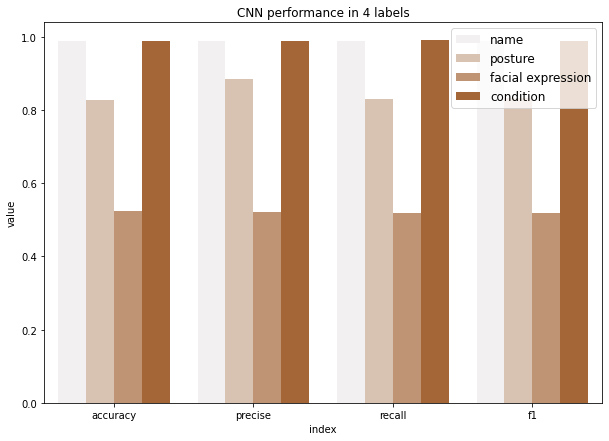

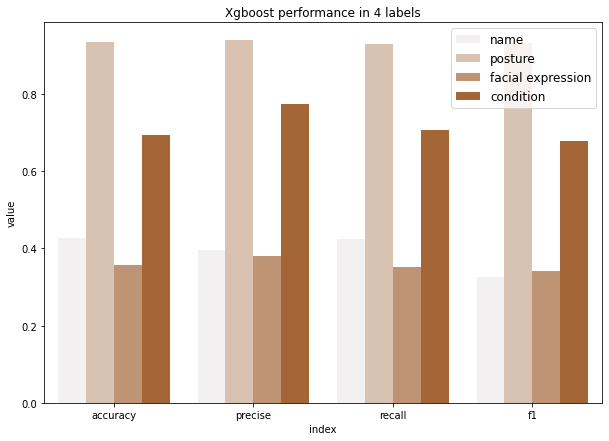

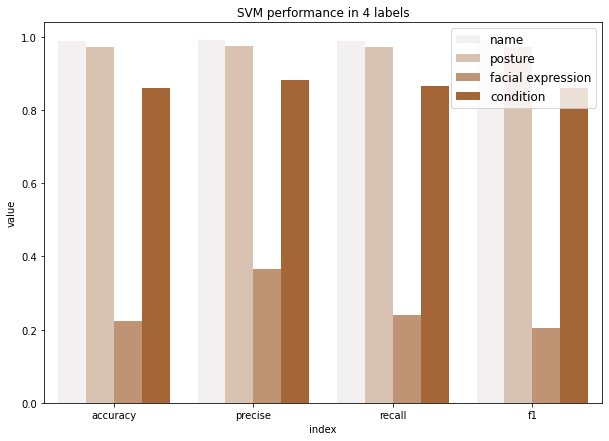

In [12]:

plotResultBar('result/ResultCNN.csv','CNN performance in 4 labels')
plotResultBar('result/ResultXGB.csv','Xgboost performance in 4 labels')
plotResultBar('result/result_SVM.csv','SVM performance in 4 labels')

Comparing results for different models, I conclude that CNN model is the optimal choice for image recognition problems, but HOG-SVM method also works well on certain labels, can be considered as a second choice.

The figures below are perfomance of 3 models on each label, accuracy, precision, recall, and F1 score are used as evaluating criteria.

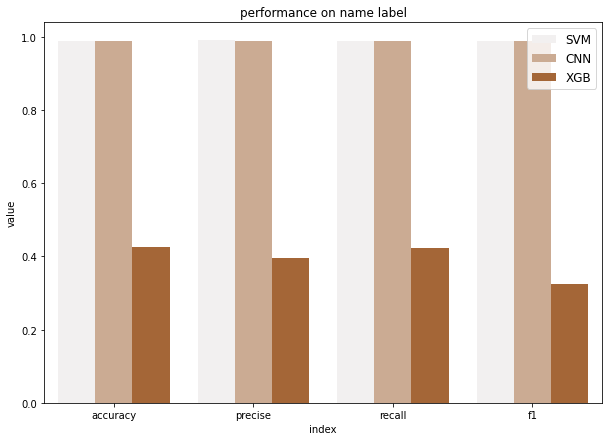

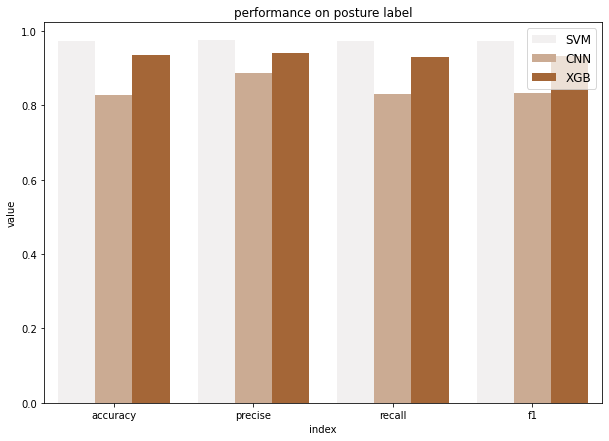

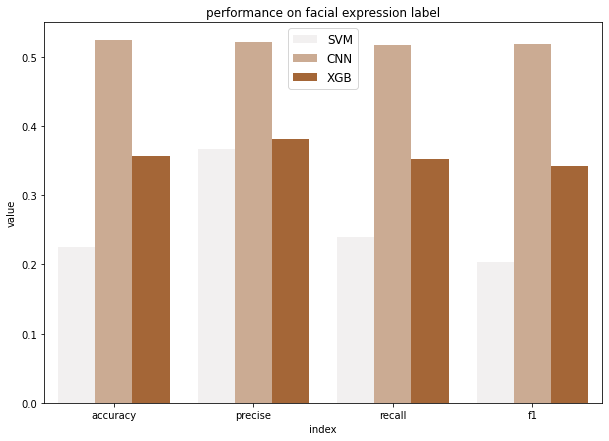

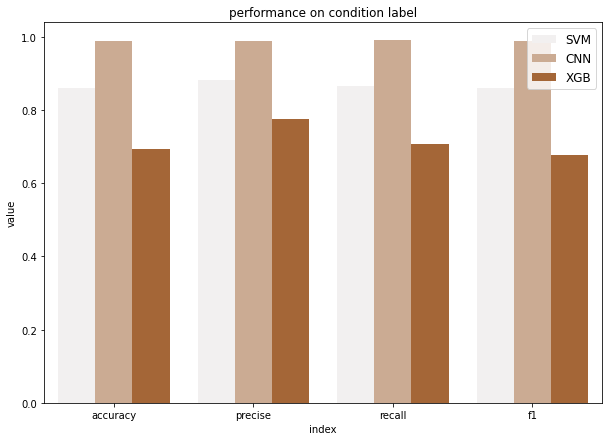

In [46]:
def plotPerformanceOnLabel(labelName):
    df_name = pd.concat([result_svm[labelName],result_cnn[labelName],result_xgb[labelName]],axis=1)
    df_name.columns = ['SVM','CNN','XGB']
    df_long = df_name.reset_index().melt(id_vars='index')

    plt.figure(figsize=(10,7))
    sns.barplot(x='index', y='value', hue='variable', data=df_long,palette=sns.light_palette("xkcd:copper", 3))
    plt.legend(fontsize='large')
    plt.title('performance on {} label'.format(labelName))
    plt.show()
plotPerformanceOnLabel('name')
plotPerformanceOnLabel('posture')
plotPerformanceOnLabel('facial expression')
plotPerformanceOnLabel('condition')

## Unsupervised learning problem
Problem to be solved: encode and compress the images, and try decoding to see the information loss

Two models I chose are PCA and autoencoder with CNN, to decide the parameter for n_component and the size of autoencoder, I firstly trained the model on 80% trainset, encode and decode the rest 20% as valid set to see the information condition in test set.

In [10]:
X_train_, X_valid_ = train_test_split(X_train_img, test_size=0.2, random_state=42)

### PCA method
Using a 20% valid set from trainset, decide the n_component kept in PCA transformation, which enables the model to keep most details in the images and less component to reduce the storage space. The decided component number is 500.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


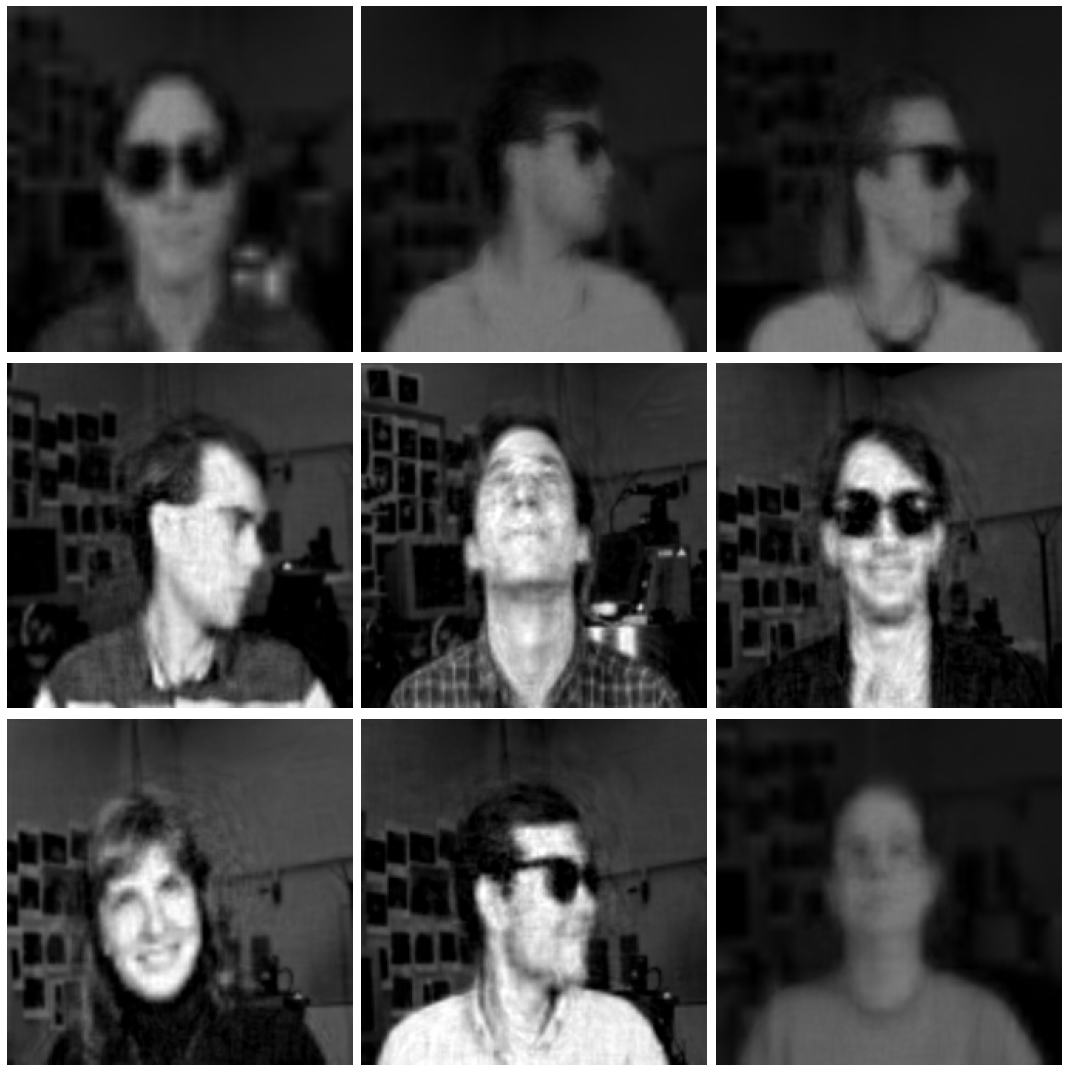

In [25]:
from sklearn.decomposition import PCA

def fitPCA(X_train_,n_components):
    n_samples, height, width, channels = X_train_.shape
    flattened_images = X_train_.reshape(n_samples, height * width * channels)

    pca = PCA(n_components=n_components)  
    pca.fit(flattened_images)
    return pca

def plotApproximation(pca,X_valid_):
    lower_dimensional_data = pca.transform(X_valid_.reshape(X_valid_.shape[0], height * width * channels))
    approximation = pca.inverse_transform(lower_dimensional_data)
    approximation = approximation.reshape(X_valid_.shape[0], height, width, channels)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for ax, photo in zip(axes.flatten(), approximation[:9]):
        ax.imshow(photo/255, cmap='gray')
        ax.axis('off')  
    #     ax.set_title(photo)  
    plt.tight_layout()
    plt.show()
pca = fitPCA(X_train_,n_components=500)
plotApproximation(pca,X_valid_)

Here follows the encoded and decoded results on test set for PCA method, we can see that most of the details are kept though the pictures are more blurry comparing to the original photos

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


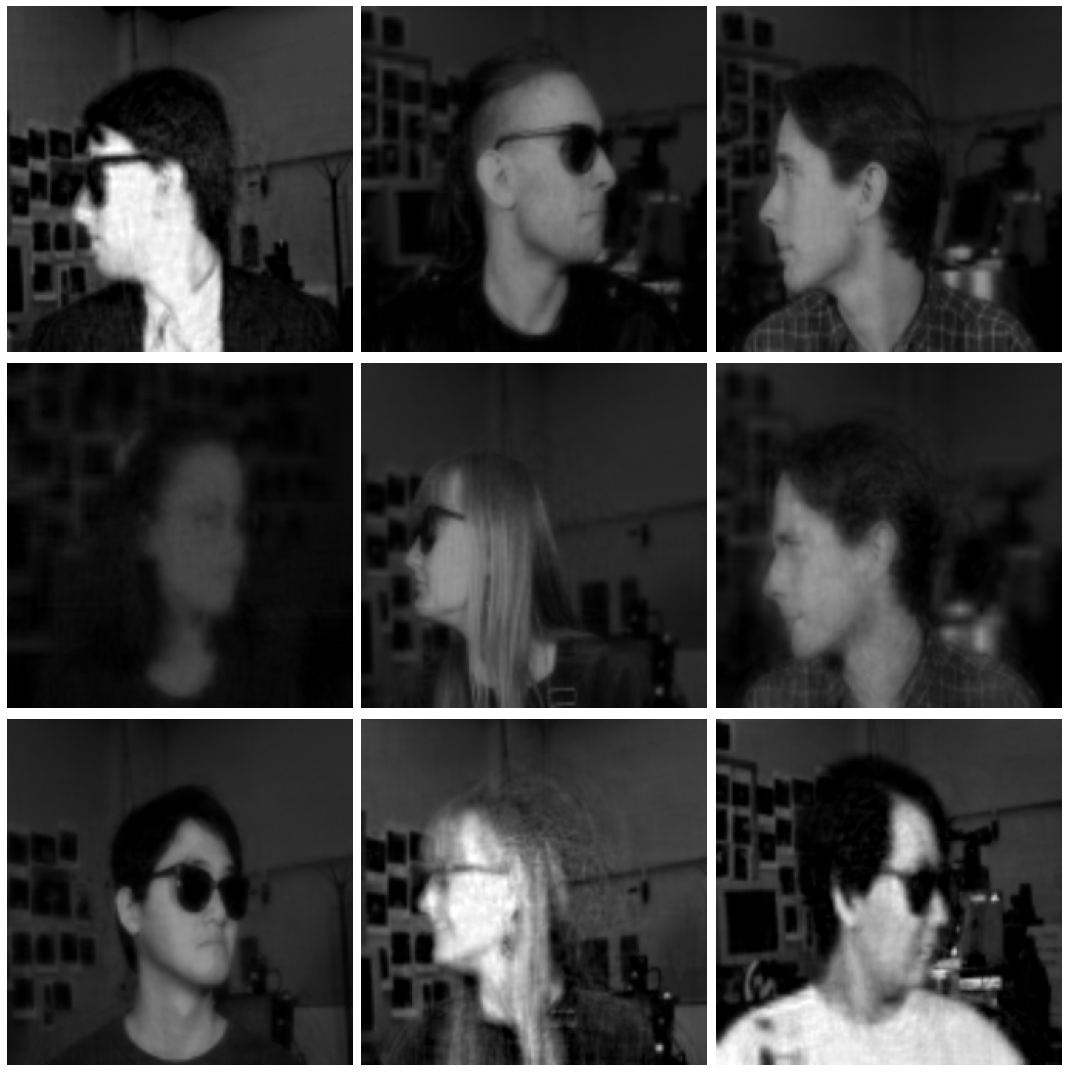

In [28]:
## the performance in test set
pca = fitPCA(X_train_img,n_components=500)
plotApproximation(pca,X_test_img)

### CNN automative encoder
The encoder and decoder contains 2 layers of convolution and 2 layers of maxpooling.

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(224, 224, 3)) 

# encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = UpSampling2D((2, 2))(encoded)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(X_train_, X_train_, epochs=10, batch_size=128, shuffle=True)

encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(X_valid_/255)
decoder = Model(encoded, decoded)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/10
10/10 [==============================] - 26s 3s/step - loss: 4675.9219
Epoch 2/10
10/10 [==============================] - 26s 3s/step - loss: 4672.2949
Epoch 3/10
10/10 [==============================] - 26s 3s/step - loss: 4672.2764
Epoch 4/10
10/10 [==============================] - 26s 3s/step - loss: 4672.2749
Epoch 5/10
10/10 [==============================] - 26s 3s/step - loss: 4672.2720
Epoch 6/10
10/10 [==============================] - 26s 3s/step - loss: 4672.2686
Epoch 7/10
10/10 [==============================] - 26s 3s/step - loss: 4672.2651
Epoch 8/10
10/10 [==============================] - 26s 3s/step - loss: 4672.2612
Epoch 9/10
10/10 [==============================] - 26s 3s/step - loss: 4672.2588
Epoch 10/10
10/10 [==============================] - 0s 43ms/step


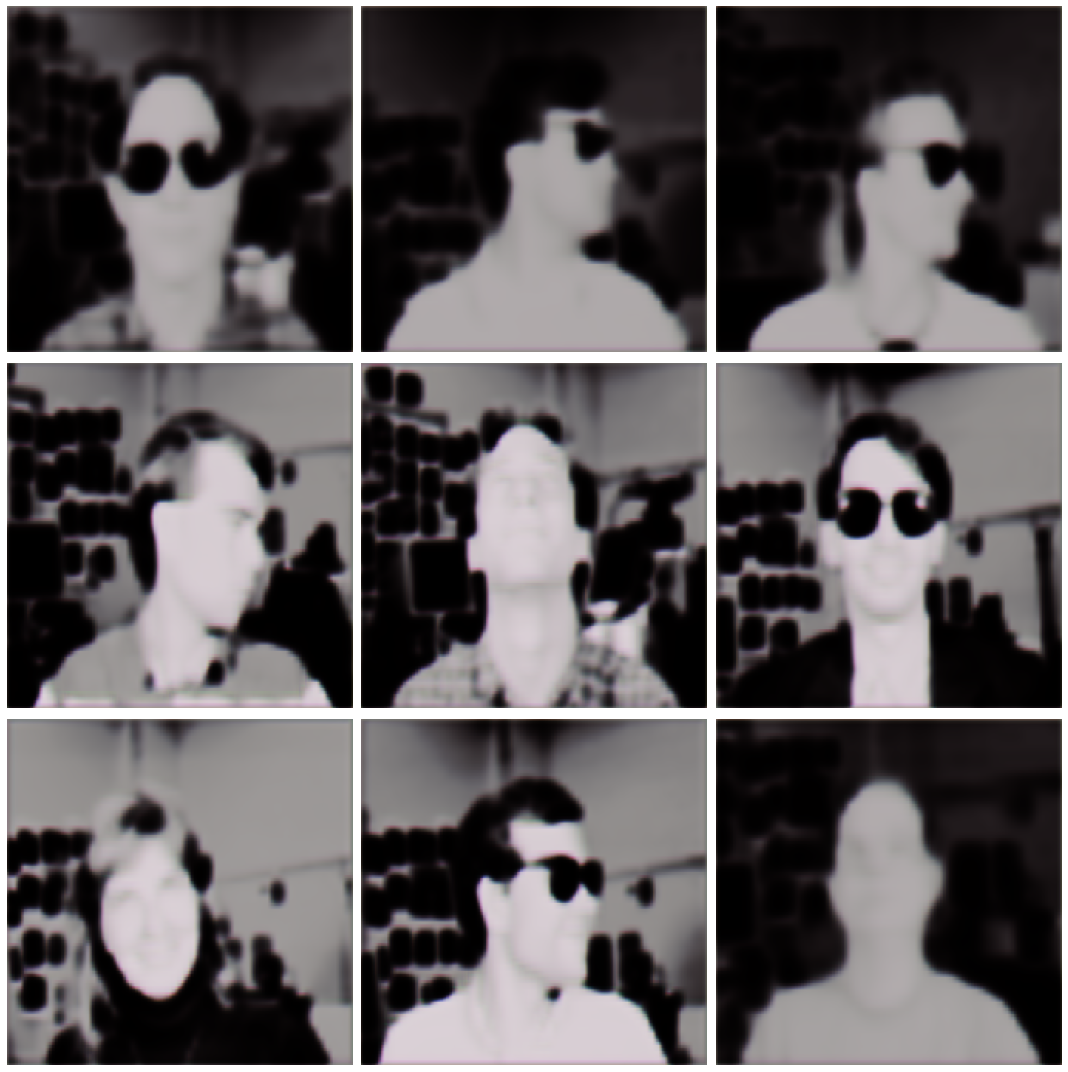

In [39]:
def plotDecoded(decoded_imgs):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for ax, photo in zip(axes.flatten(), decoded_imgs[:9]*255):
        ax.imshow(photo/255, cmap='gray')
        ax.axis('off')  

    #     ax.set_title(photo)  
    plt.tight_layout()
    plt.show()
plotDecoded(decoded_imgs)

As displayed below, the decoded images contains less detail comparing to PCA result, but the details of the contour of human face and the main features in the background are retained.

12/12 [==============================] - 1s 46ms/step


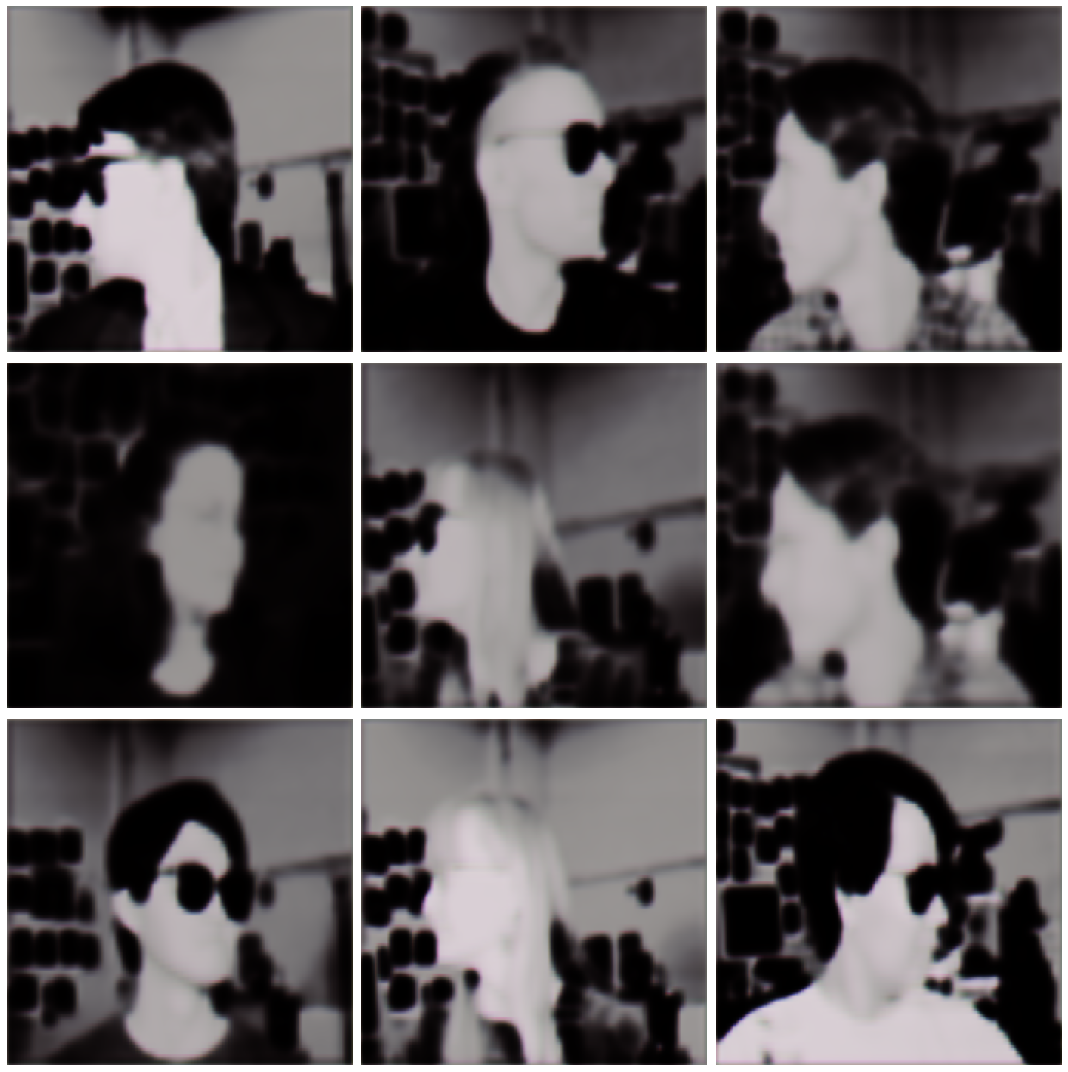

In [41]:
encoded_imgs = encoder.predict(X_test_img/255)
decoded_imgs = decoder.predict(encoded_imgs)
plotDecoded(decoded_imgs)